In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import math
from pandas.core.series import Series
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from pandas import DataFrame
from tqdm.auto import tqdm
import warnings

tqdm.pandas()

plt.style.use('ggplot')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#8d9bff', '#FF9750', '#FFD900','#7BB5C4', '#9FC1AD', '#D3D3E0'])

warnings.filterwarnings("ignore")

def calculate_distance(responde: Series, llm: DataFrame, preguntas_seleccionadas: dict):
    result = 0
    num_pregs = 0
    no_responden = 0

    preguntas = list(preguntas_seleccionadas.keys())

    for pregunta in preguntas:
        pregunta_normalizada = pregunta.lower()
        respuesta_llm = llm[llm['Pregunta'] == pregunta]['Respuesta'].values[0]
        

        if pregunta_normalizada in responde.keys():
            respuesta = responde[pregunta_normalizada]
            respondio = not math.isnan(respuesta)

            if respondio and pregunta in list(llm['Pregunta']) and respuesta_llm < 10:
                result += abs(respuesta - respuesta_llm)
                num_pregs += 1

        if not pregunta_normalizada.startswith('ovq') and not pregunta_normalizada.startswith('trade'):
            respuesta = responde[pregunta_normalizada]
            respondio = not math.isnan(respuesta)
            
            if respuesta_llm > 10 or not respondio:
                no_responden += 1
            
    if num_pregs == 0:
        result = -1
        norm_result = -1
    else:
        norm_result = result/num_pregs
    
    return result, num_pregs, norm_result

# Crea un StataReader para leer los metadatos
reader = pd.io.stata.StataReader('./datasets/ARG_2021_LAPOP_AmericasBarometer_v1.2_w.dta')

In [2]:
with open("./datasets/respuestas.pickle", "rb") as input_file:
    respuestas = pickle.load(input_file)

with open("./datasets/preguntas_seleccionadas.pickle", "rb") as input_file:
    preguntas_seleccionadas = pickle.load(input_file)

In [3]:
lpop    = pd.read_stata('./datasets/ARG_2021_LAPOP_AmericasBarometer_v1.2_w.dta', convert_categoricals=False)
chatgpt = pd.read_csv('./outputs/respuestas_gpt35_turbo.csv')

In [4]:
lpop['gpt_results'] = lpop.progress_apply(lambda x: calculate_distance(x, chatgpt, preguntas_seleccionadas), axis=1)
lpop[['gpt_distance', 'gpt_num_preg','gpt_distance_norm']] = pd.DataFrame(lpop['gpt_results'].tolist(), index=lpop.index)

  0%|          | 0/3011 [00:00<?, ?it/s]

In [5]:
lpop[lpop['gpt_num_preg'] >5].to_csv('./outputs/lpop_gpt_distances.csv')

<Axes: ylabel='Frequency'>

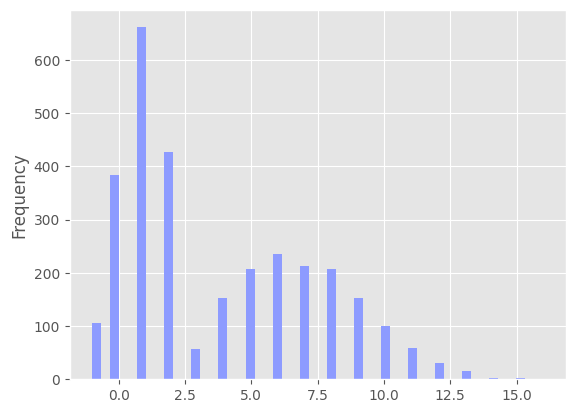

In [6]:
lpop['gpt_distance'].plot(kind='hist', bins=50)

<Axes: ylabel='Frequency'>

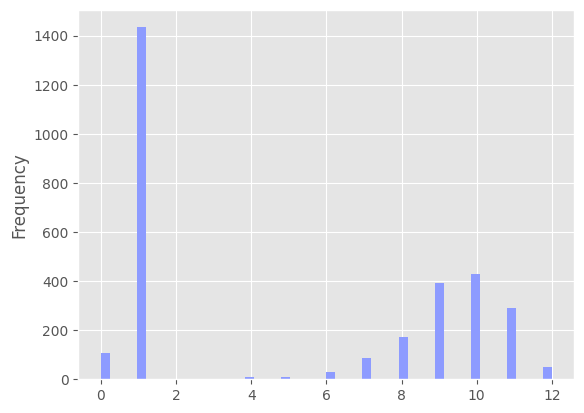

In [7]:
lpop['gpt_num_preg'].plot(kind='hist', bins=50)

<Axes: ylabel='Frequency'>

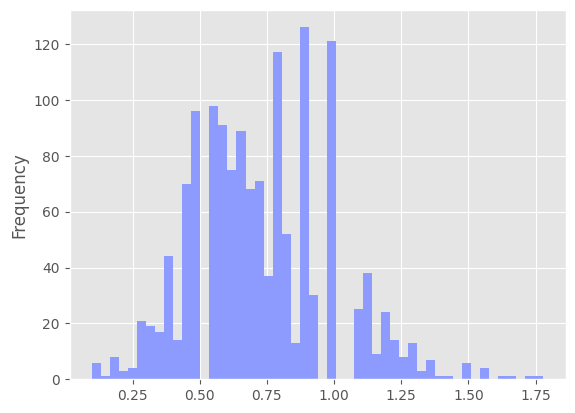

In [8]:
lpop[lpop['gpt_num_preg']>5]['gpt_distance_norm'].plot(kind='hist', bins=50)

---

# Edad

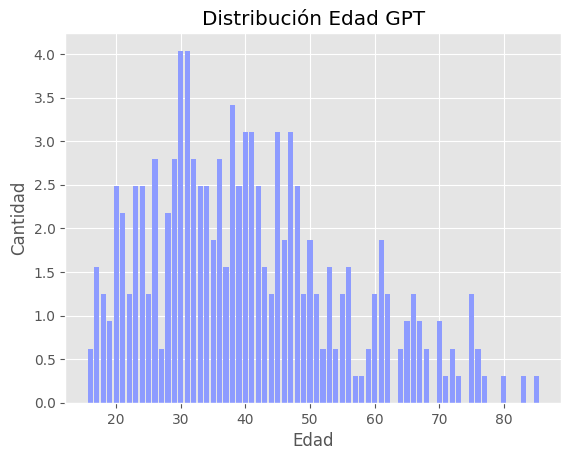

In [9]:
lpop_gpt =  lpop[(lpop['gpt_distance_norm']<=1)&(lpop['gpt_num_preg']>10)]

plt.figure(dpi=100)
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_gpt['q2'].value_counts()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.title("Distribución Edad GPT", color='black')
plt.ylabel("Cantidad")
plt.xlabel("Edad")
plt.show()

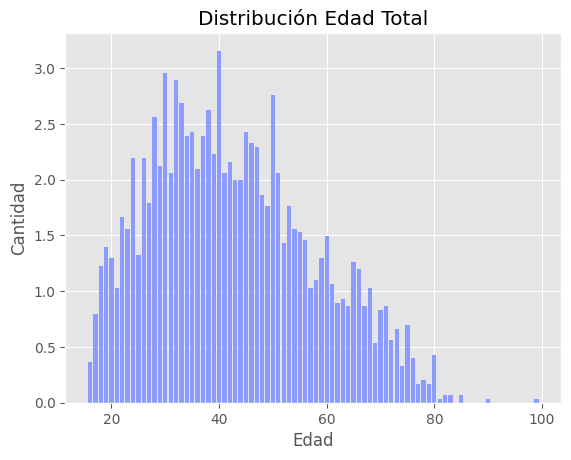

In [10]:
plt.figure(dpi=100)

# Realiza la suma ponderada por grupo
users_per_grade = lpop['q2'].value_counts()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.title("Distribución Edad Total", color='black')
plt.ylabel("Cantidad")
plt.xlabel("Edad")
plt.show()

In [11]:
# Realizar la prueba t
estadistico, p_valor = ttest_ind((lpop_gpt['q2'].values), (lpop['q2'].values))

print("Estadístico de prueba t:", estadistico)
print("Valor p:", p_valor)

Estadístico de prueba t: -2.522807773381545
Valor p: 0.011688400441977182


---

# Género

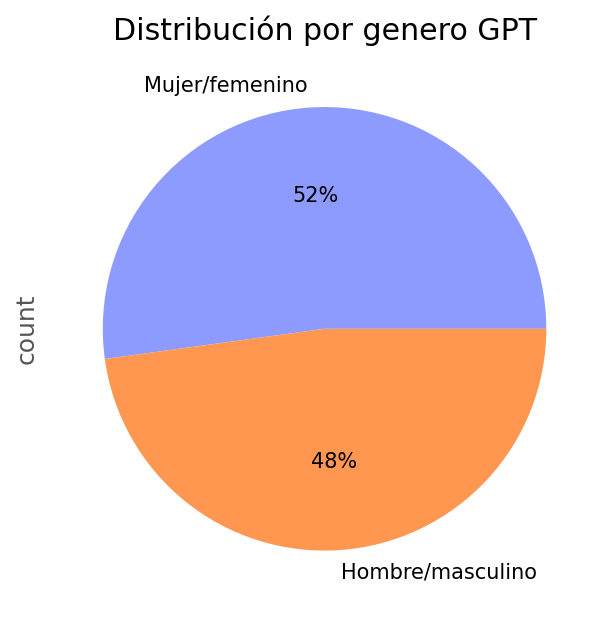

In [12]:
lpop_gpt['q1tb_label'] = lpop_gpt['q1tb'].apply(lambda x: reader.value_labels()['q1tb_esp'][x])

plt.figure(figsize=(6.4, 4.8), dpi=150)

# textcolor black
lpop_gpt['q1tb_label'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color': 'black'}
)

plt.title('Distribución por genero GPT', color='black')
plt.savefig('./outputs/genero_chatGPT.png')
plt.show()

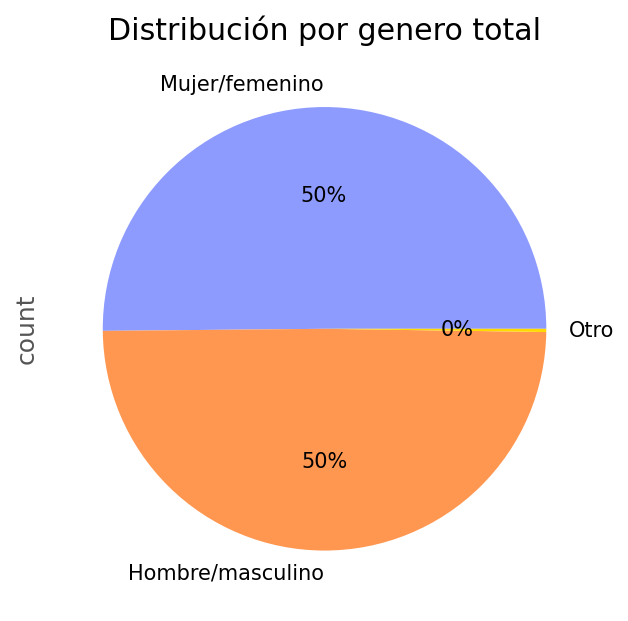

In [13]:
lpop['q1tb_label'] = lpop['q1tb'].apply(lambda x: reader.value_labels()['q1tb_esp'][x])

plt.figure(figsize=(6.4, 4.8), dpi=150)
lpop['q1tb_label'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color': 'black'}
)

plt.title('Distribución por genero total', color='black')
plt.savefig('./outputs/genero_total.png')
plt.show()

In [14]:
# tamaños de las muestras
n_total = lpop.shape[0]
n_submuestra = lpop_gpt.shape[0]

# número de éxitos (en este caso, mujeres) en cada muestra
count_total = n_total * 0.50  # 50% de la muestra total son mujeres
count_submuestra = n_submuestra * 0.49  # 55% de la submuestra son mujeres

# realizamos el test de proporciones
z_stat, p_value = proportions_ztest([count_submuestra, count_total], [n_submuestra, n_total])

print('Z-statistic:', z_stat)
print('p-value:', p_value)

Z-statistic: -0.341111580090423
p-value: 0.7330195838416471


---

# Provincia

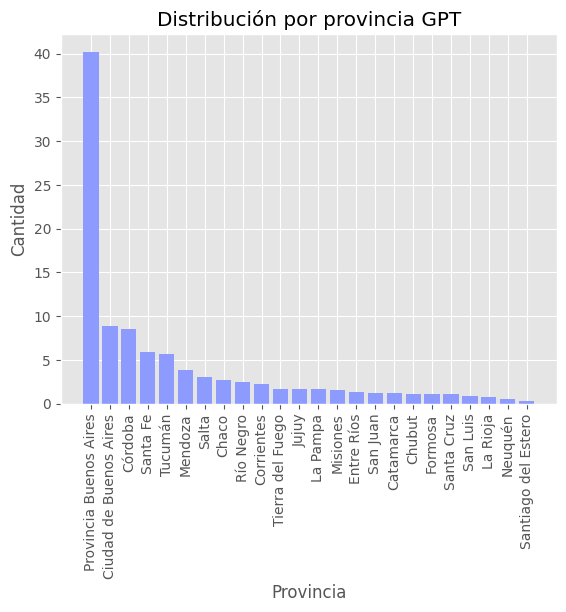

In [15]:
lpop_gpt['prov1t_label'] = lpop_gpt['prov1t'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['prov1t_eng'][x])

plt.figure(dpi=100)
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_gpt.groupby('prov1t_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Provincia")
plt.title('Distribución por provincia GPT', color='black')
plt.xticks(rotation=90)
plt.show()

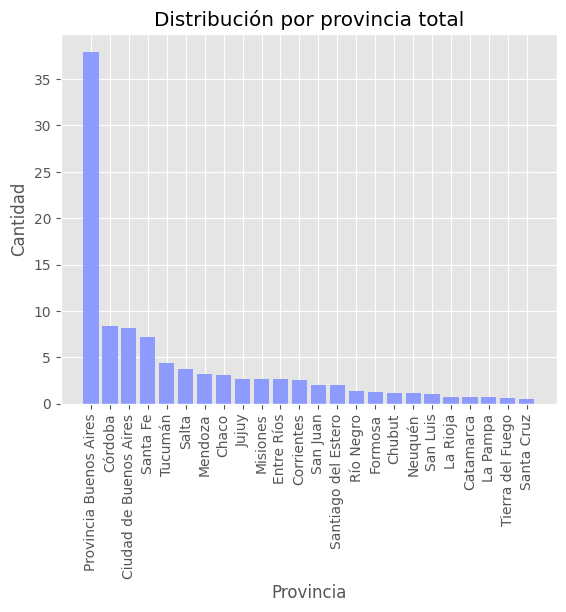

In [16]:
lpop['prov1t_label'] = lpop['prov1t'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['prov1t_eng'][x])

plt.figure(dpi=100)
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('prov1t_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Provincia")
plt.title('Distribución por provincia total', color='black')
plt.xticks(rotation=90)
plt.show()

In [17]:
# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([list(users_per_grade_gpt.values), list(users_per_grade_total.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 26.79452206109218
Valor p: 0.26481184959763265


---

# Urbanización

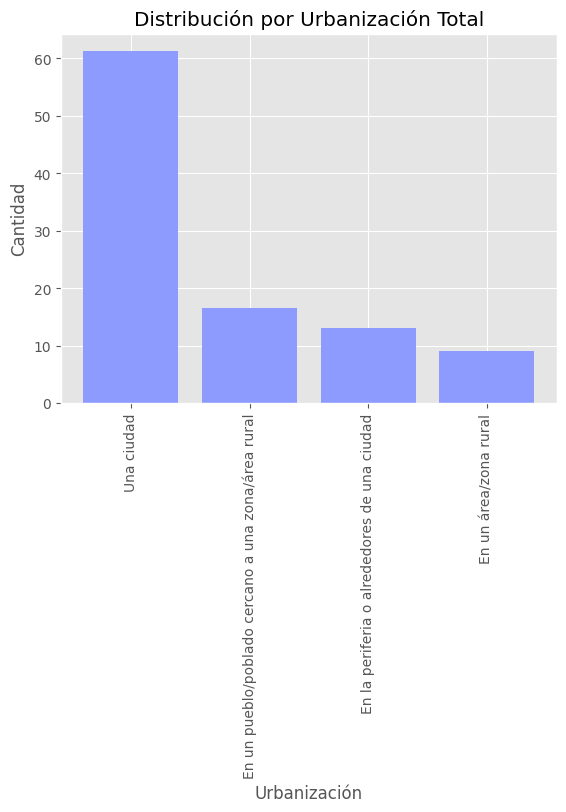

In [18]:
lpop_gpt['ur1new_label'] = lpop_gpt['ur1new'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['ur1new_esp'][x])
lpop['ur1new_label'] = lpop['ur1new'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['ur1new_esp'][x])

plt.figure(dpi=100)
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('ur1new_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Urbanización")
plt.title('Distribución por Urbanización Total', color='black')
plt.xticks(rotation=90)
plt.show()

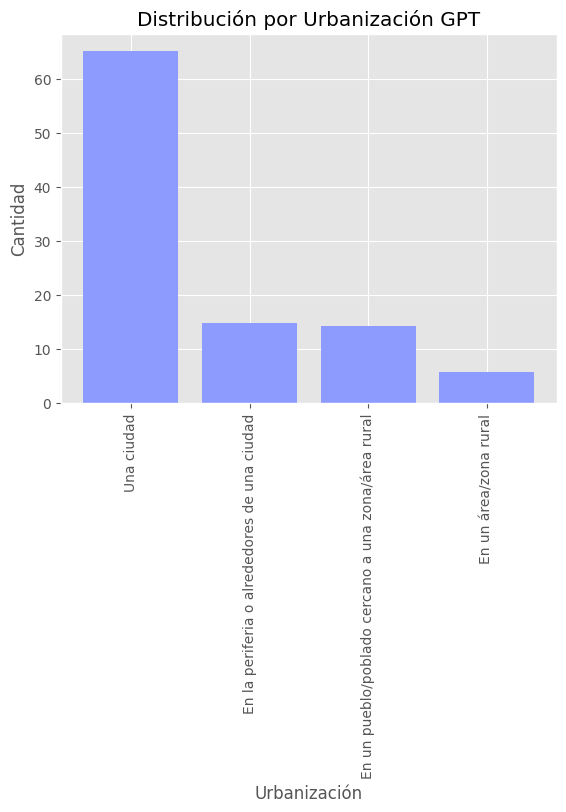

In [19]:
plt.figure(dpi=100)
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_gpt.groupby('ur1new_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Urbanización")
plt.title('Distribución por Urbanización GPT', color='black')
plt.xticks(rotation=90)
plt.show()

In [20]:
# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([list(users_per_grade_gpt.values), list(users_per_grade_total.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 5.651948532899076
Valor p: 0.12982765897489248


---

# Nivel educativo

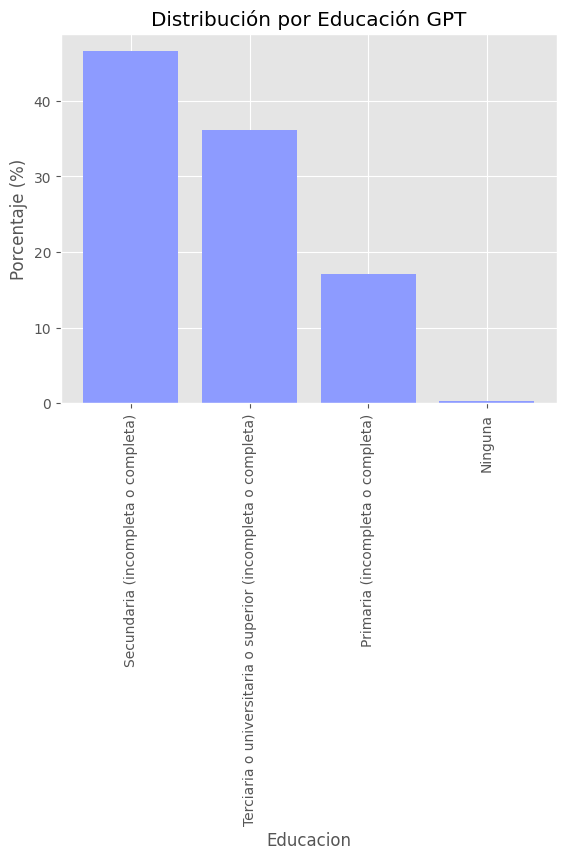

In [21]:
lpop_gpt['edr_label'] = lpop_gpt['edr'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['edr_esp'][x])

plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_gpt.groupby('edr_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Educacion")
plt.title('Distribución por Educación GPT', color='black')
plt.xticks(rotation=90)
plt.show()

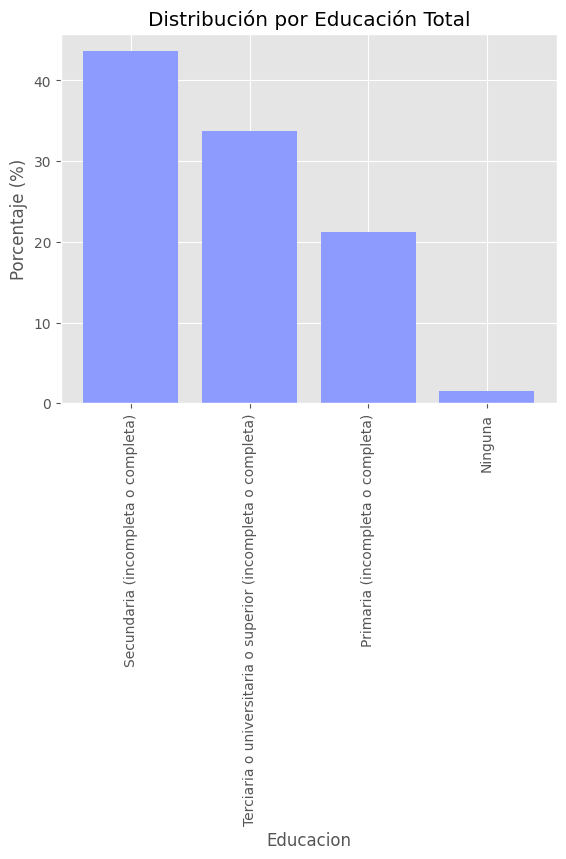

In [22]:
lpop['edr_label'] = lpop['edr'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['edr_esp'][x])

plt.figure(dpi=100)
# Realiza la suma ponderada por grupo
users_per_grade = lpop.groupby('edr_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted_total = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted_total.index, users_per_grade_pct_sorted_total.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Educacion")
plt.title('Distribución por Educación Total', color='black')
plt.xticks(rotation=90)
plt.show()

In [23]:
# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 6.117218232074175
Valor p: 0.10604450462219099


---

# Ingresos

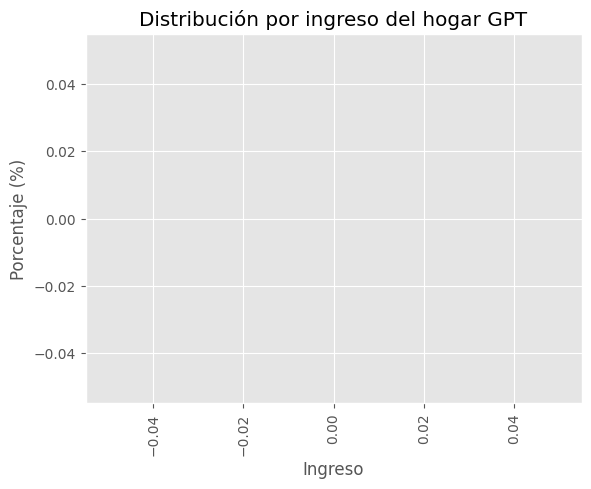

In [24]:
lpop_gpt['q10newt_label'] = lpop_gpt['q10newt'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['q10newt_esp'][x])

plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade = lpop_gpt.groupby('q10newt_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Ingreso")
plt.title('Distribución por ingreso del hogar GPT', color='black')
plt.xticks(rotation=90)
plt.show()

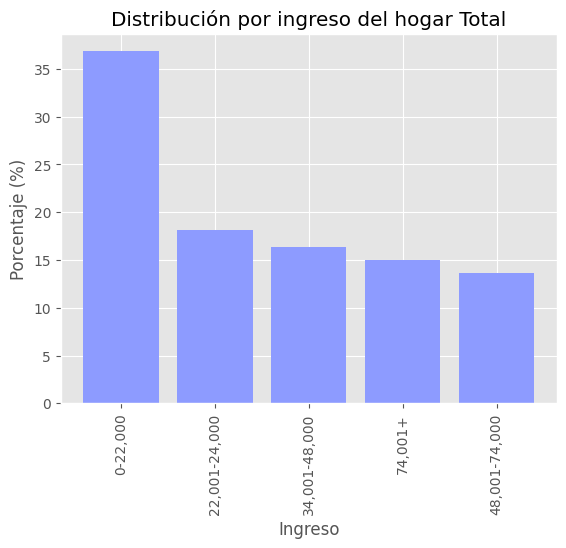

In [25]:
lpop['q10newt_label'] = lpop['q10newt'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['q10newt_esp'][x])

plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('q10newt_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Ingreso")
plt.title('Distribución por ingreso del hogar Total', color='black')
plt.xticks(rotation=90)
plt.show()

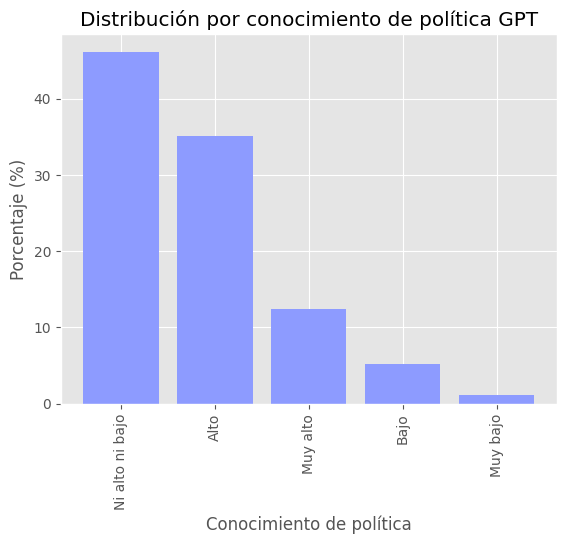

In [26]:
lpop_gpt['conocim_label'] = lpop_gpt['conocim'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['conocim_esp'][x])

plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade = lpop_gpt.groupby('conocim_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade / users_per_grade.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Conocimiento de política")
plt.title('Distribución por conocimiento de política GPT', color='black')
plt.xticks(rotation=90)
plt.show()

---

# Conocimiento de política

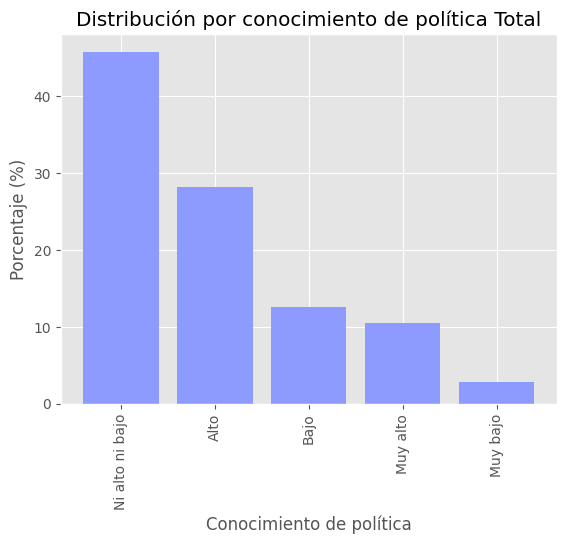

In [27]:
lpop['conocim_label'] = lpop['conocim'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['conocim_esp'][x])

plt.figure(dpi=(100))
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('conocim_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Porcentaje (%)")
plt.xlabel("Conocimiento de política")
plt.title('Distribución por conocimiento de política Total', color='black')
plt.xticks(rotation=90)
plt.show()

In [28]:
# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([ list(users_per_grade_total.values),list(users_per_grade.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 21.44142771752578
Valor p: 0.00025882557803294623


---

# Etnicidad

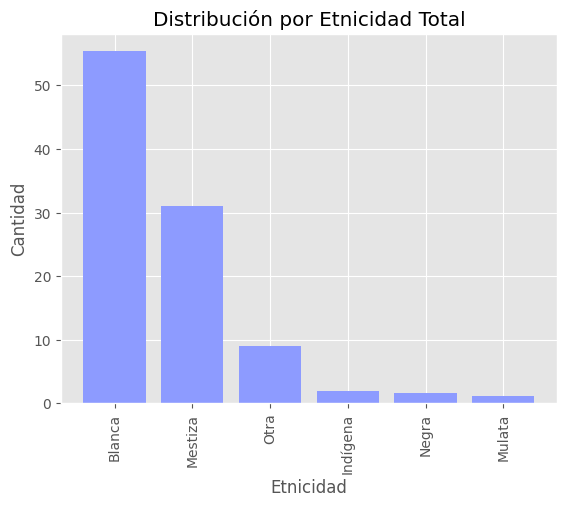

In [29]:
lpop_gpt['etid_label'] = lpop_gpt['etid'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['etid_esp'][x])
lpop['etid_label'] = lpop['etid'].apply(lambda x: None if math.isnan(x) else reader.value_labels()['etid_esp'][x])

plt.figure(dpi=100)
# Realiza la suma ponderada por grupo
users_per_grade_total = lpop.groupby('etid_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct = users_per_grade_total / users_per_grade_total.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Etnicidad")
plt.title('Distribución por Etnicidad Total', color='black')
plt.xticks(rotation=90)
plt.show()


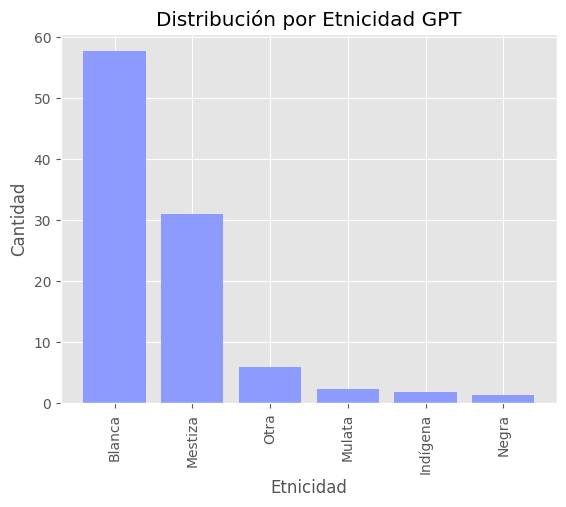

In [30]:
plt.figure(dpi=100)
# Realiza la suma ponderada por grupo
users_per_grade_gpt = lpop_gpt.groupby('etid_label')['wt'].sum()

# Convierte la suma ponderada en porcentajes
users_per_grade_pct_gpt = users_per_grade_gpt / users_per_grade_gpt.sum() * 100

# Ordena los valores
users_per_grade_pct_sorted = users_per_grade_pct_gpt.sort_values(ascending=False)

plt.bar(users_per_grade_pct_sorted.index, users_per_grade_pct_sorted.values)
plt.ylabel("Cantidad")
plt.xlabel("Etnicidad")
plt.title('Distribución por Etnicidad GPT', color='black')
plt.xticks(rotation=90)
plt.show()

In [31]:
# Realizar el test de chi-cuadrado
#chi2, p_valor = chi2_contingency([list(users_per_grade.values), list(users_per_grade_gpt.values)])
chi2, p_valor, _, _ = chi2_contingency([ list(users_per_grade_total.values),list(users_per_grade_gpt.values)])

print("Estadístico de chi-cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico de chi-cuadrado: 7.063643392427036
Valor p: 0.21594993875825552


***
***

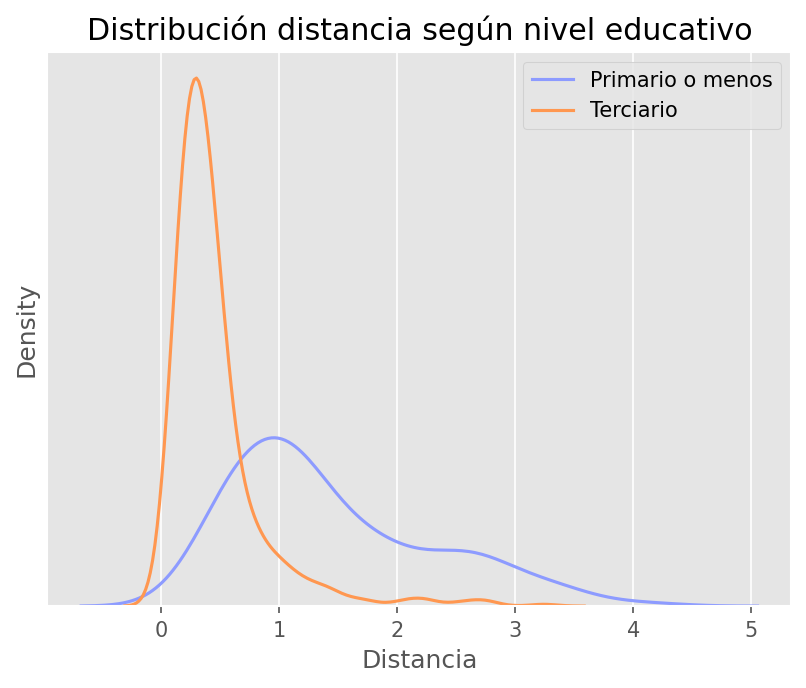

In [32]:
lpop['gpt_distance_norm_wt'] =  lpop['gpt_distance_norm'] * lpop['wt']
lpop_adulto = lpop[lpop['edr']<=1]
lpop_joven = lpop[lpop['edr']==3]
plt.figure(dpi=150)

sns.kdeplot(
   lpop_adulto[lpop_adulto['gpt_num_preg']>8]['gpt_distance_norm_wt'], label="Primario o menos", linewidth=1.5
)
sns.kdeplot(
   lpop_joven[lpop_joven['gpt_num_preg']>8]['gpt_distance_norm_wt'], label="Terciario", linewidth=1.5
)
plt.title("Distribución distancia según nivel educativo", color='black')
plt.xlabel("Distancia")
plt.yticks([], [])
legend = plt.legend(loc='upper right')
legend.get_texts()[0].set_color('black')
legend.get_texts()[1].set_color('black')
plt.show()

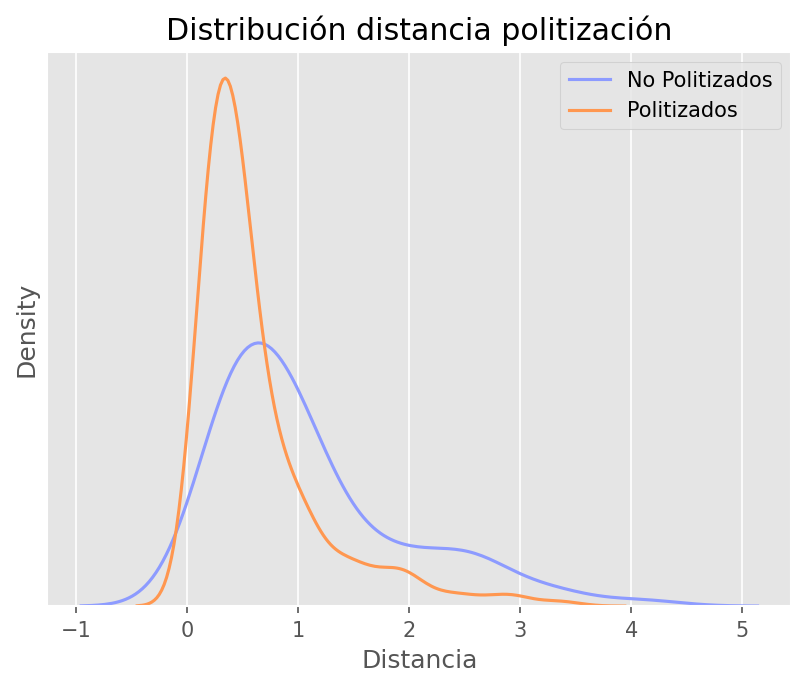

In [33]:
lpop_adulto = lpop[lpop['conocim']<=2]
lpop_joven = lpop[lpop['conocim']>=4]
plt.figure(dpi=150)

sns.kdeplot(
   lpop_joven[lpop_joven['gpt_num_preg']>8]['gpt_distance_norm_wt'], label="No Politizados", linewidth=1.5
)
sns.kdeplot(
   lpop_adulto[lpop_adulto['gpt_num_preg']>8]['gpt_distance_norm_wt'], label="Politizados", linewidth=1.5
)
plt.title("Distribución distancia politización", color='black')
plt.xlabel("Distancia")
plt.yticks([], [])
legend = plt.legend(loc='upper right')
legend.get_texts()[0].set_color('black')
legend.get_texts()[1].set_color('black')
plt.show()